In [42]:
# Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any

In [43]:
IMG_SIZE: int = 518
RESIZE_DIM: int = IMG_SIZE + 2
PATCH_SIZE: int = 14
FEAT_DIM: int = 384 # for vits
PATCH_W: int = IMG_SIZE // PATCH_SIZE
PATCH_H: int = IMG_SIZE // PATCH_SIZE

transform = transforms.Compose([           
    transforms.Resize(RESIZE_DIM),
    transforms.CenterCrop(IMG_SIZE),            
    transforms.ToTensor(),                    
    transforms.Normalize(mean=0.5, std=0.2)
])

Load model here. Add '_lc' to load the ImageNet 1k linear classifier version, but we just want the features.

In [44]:
dinov2_vits14: nn.Module  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()
dinov2_vits14.cuda()
pass # here to flush stdout

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [45]:
def get_img_features(img_tensor: torch.Tensor, model: Any) -> np.ndarray:
    features_dict = model.forward_features(img_tensor.unsqueeze(0))
    features = features_dict["x_norm_patchtokens"]
    return features.detach().cpu().numpy()

In [55]:
def load_image(path: str, transform: transforms.Compose) -> Tuple[torch.tensor, Image.Image]:
    image = Image.open(path)
    tensor = transform(image)
    return tensor, image

def get_pca_features(feat_arr: np.ndarray, n_patches_h: int, n_patches_w: int, feat_dim: int, n_components:int =3) -> np.ndarray:
    #  Take np array output of DINOv2 and compute $n_components principal components.
    reshaped_features: np.ndarray = feat_arr.reshape(n_patches_h * n_patches_w, feat_dim)
    pca = PCA(n_components=n_components)
    pca.fit(reshaped_features)
    pca_features = pca.transform(reshaped_features)
    return pca_features

def plot_pca_hists(pcas: List[np.ndarray], n_components: int=3, labels: List[str]=[], show_first: bool=True) -> None:
    n_imgs = len(pcas)
    n_plots = n_components + 1 if show_first is True else n_components
    fig, axs = plt.subplots(n_imgs, n_plots)
    fig.set_size_inches(12, 4)
    for i in range(n_imgs):
        for j in range(n_plots):
            ax: plt.axes = axs[i, j] if n_imgs > 1 else axs[j]
            if j == 0 and show_first: # draw first component spatially
                ax.imshow(pcas[i][:, j].reshape(PATCH_H, PATCH_W))
            else: # plot hist
                component = pcas[i][:, j - 1]
                ax.hist(component, bins=20)

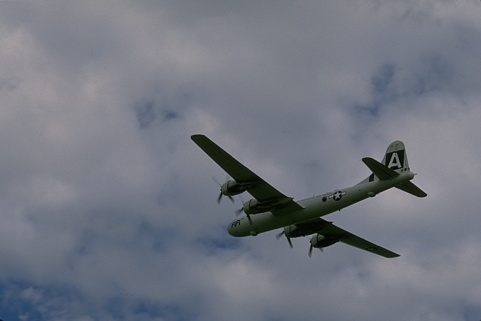

In [47]:
plane_tensor, plane_img = load_image("data/BSD300/train/3096.jpg", transform)
plane_tensor = plane_tensor.to('cuda')
plane_img

In [49]:
dino_features_arr = get_img_features(plane_tensor, dinov2_vits14)
pca_features_arr = get_pca_features(dino_features_arr, PATCH_H, PATCH_W, FEAT_DIM)

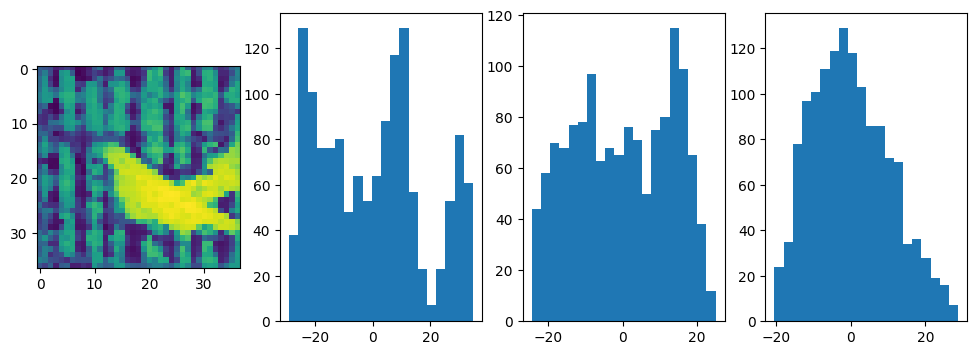

In [56]:
plot_pca_hists([pca_features_arr])

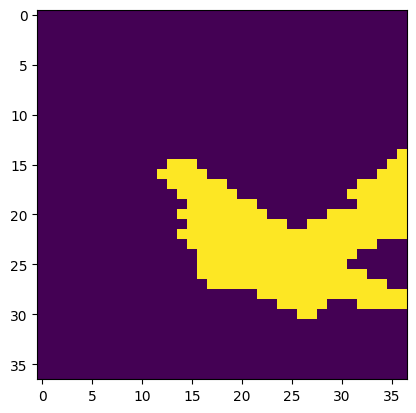

In [54]:
fg = pca_features_arr[:, 0] > 20
plt.imshow(fg.reshape(PATCH_H, PATCH_W))

Could compute KL div/similarity between average/random pairs within datasets and across datasets to show difference? However, this only shows difference and not suboptimality (need loss for that)